In [11]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
bigger_fire = pd.read_csv('../../data/cleaned/bigger_wildfire_weather_extra.csv')

In [24]:
bigger_fire['fuel_moisture'] = bigger_fire['relative_humidity'] / 5

C:\Users\btoli\AppData\Local\Temp\ipykernel_32412\829062287.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr= round(bigger_fire.corr()[['dailyacres']].sort_values(by='dailyacres', ascending=False), 2)


<AxesSubplot: >

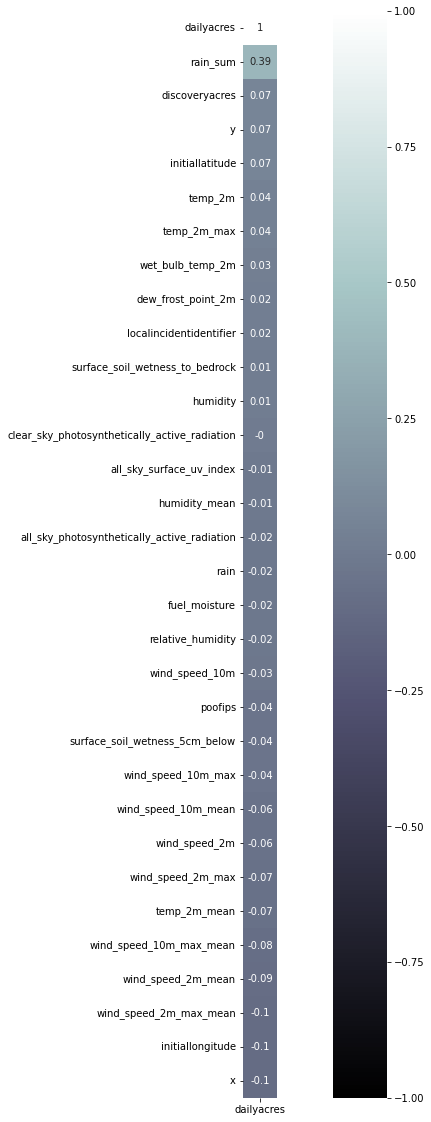

In [25]:
plt.figure(figsize=(20, 20))
corr= round(bigger_fire.corr()[['dailyacres']].sort_values(by='dailyacres', ascending=False), 2)
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
    # mask=mask, 
    square = True, 
    cmap='bone', 
    annot =True,
    vmin=-1, 
    vmax=1)

In [26]:
test_df = bigger_fire.drop(
    columns=[
        "y",
        "initiallatitude",
        "temp_2m",
        "localincidentidentifier",
        "humidity",
        "surface_soil_wetness_5cm_below",
        "dew_frost_point_2m",
        "humidity_mean",
        "wind_speed_10m",
        "wind_speed_10m_mean",
        "wind_speed_10m_max",
        "wind_speed_2m",
        "wind_speed_10m_max_mean",
        "wind_speed_2m_max",
        "wind_speed_2m_mean",
        "initiallongitude",
        "x"
    ]
)

test_df.corr()[["dailyacres"]].sort_values(by="dailyacres", ascending=False)


C:\Users\btoli\AppData\Local\Temp\ipykernel_32412\3329781329.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_df.corr()[["dailyacres"]].sort_values(by="dailyacres", ascending=False)


,dailyacres
dailyacres,1.000000
rain_sum,0.390590
discoveryacres,0.070188
temp_2m_max,0.036556
wet_bulb_temp_2m,0.034488
surface_soil_wetness_to_bedrock,0.010964
clear_sky_photosynthetically_active_radiation,-0.003335
all_sky_surface_uv_index,-0.006055
all_sky_photosynthetically_active_radiation,-0.016636
rain,-0.016821


> It does not look like extra weather dataset helped 
> 

----
EDA on wildfire dataset

In [17]:
fire = pd.read_csv('../../data/processed/wildfire_weather.csv')
fire.head(1)

,id,x,y,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,incidenttypecategory,...,wind_speed_10m_max,surface_soil_wetness_5cm_below,surface_soil_wetness_to_bedrock,wind_speed_2m_mean,wind_speed_2m_max_mean,wind_speed_10m_mean,wind_speed_10m_max_mean,humidity_mean,temp_2m_mean,rain_sum
0,0,-111.348611,33.195755,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,8.0,2.5,Human,2020-07-22 21:51:00+00:00,WF,...,3.84,0.12,0.38,1.41,3.09,1.895,4.18,13.21,29.9,2.6


In [19]:
fire.shape

(21537, 37)

C:\Users\btoli\AppData\Local\Temp\ipykernel_32412\987730325.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr= round(fire.corr()[['dailyacres']].sort_values(by='dailyacres', ascending=False), 2)


<AxesSubplot: >

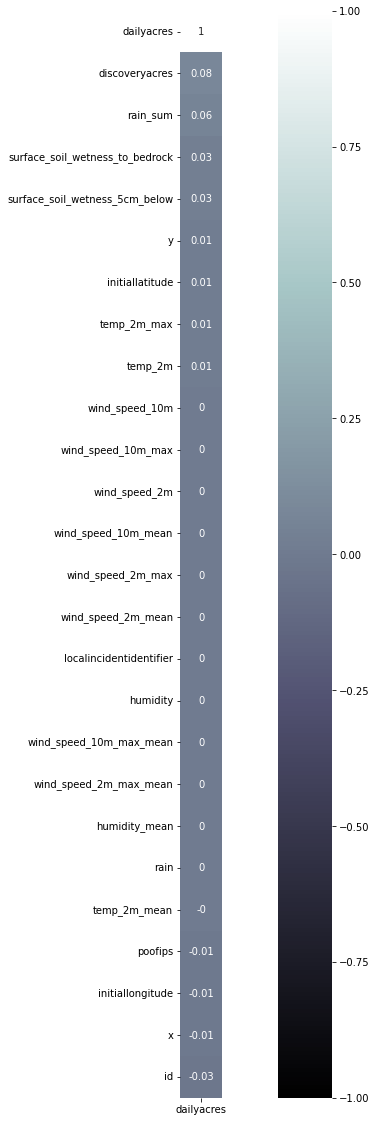

In [20]:
plt.figure(figsize=(20, 20))
corr= round(fire.corr()[['dailyacres']].sort_values(by='dailyacres', ascending=False), 2)
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
    # mask=mask, 
    square = True, 
    cmap='bone', 
    annot =True,
    vmin=-1, 
    vmax=1)